In [55]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import umap.umap_ as umap

from modules import processor

In [56]:
pd.set_option('display.max_colwidth', None)
PATH = '/Users/kaledinaoa/data/data_sber_market_test_ml/'

raw_data = processor.load_csv("train", PATH)
sample_sumbission = processor.load_csv("sample_submission", PATH)

In [59]:
raw_data.head(3)
# test_df = raw_data.copy()


,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198


In [62]:
def split_to_train_test_last_day(df):
        
        date_column = 'order_completed_at'
        
        df_clean_sorted = df.sort_values(by=['user_id', date_column])
        grouped_df = df_clean_sorted.groupby('user_id')

        train_data = []
        test_data = []

        for user_id, group_df in grouped_df:
            # Получаем последнюю дату для данного пользователя
            last_date = group_df[date_column].max()
            # Выбираем все записи кроме последней даты для обучающего набора
            train_data.append(group_df[group_df[date_column] != last_date])
            # Выбираем все записи на последнюю дату для тестового набора
            test_data.append(group_df[group_df[date_column] == last_date])

        train_df = pd.concat(train_data)
        test_df = pd.concat(test_data)

        return train_df, test_df

In [63]:
train_df, test_df = split_to_train_test_last_day(raw_data)

In [66]:
def print_df_info(df, id='user_id', tr='order_completed_at'):
    users, items, interactions = df[id].nunique(), df[tr].nunique(), df.shape[0]
    # info_str = '# users: ' + str(users) + ' # items: ' + str(items) + ' # interactions: ' + str(interactions)
    str = """users: {us:5}, items: {it:5}, interactions: {inter:7}""".format(us=users, it=items, inter=interactions)
    return str

print("raw_data:   ", print_df_info(raw_data))
print("train_df:   ", print_df_info(train_df))
print("test_df:    ", print_df_info(test_df))

raw_data:    users: 20000, items: 208155, interactions: 3123064
train_df:    users: 20000, items: 188458, interactions: 2841987
test_df:     users: 20000, items: 19923, interactions:  281077


In [113]:
test_df.head()

,user_id,order_completed_at,cart
3097178,0,2020-09-02 07:38:25,803
3097179,0,2020-09-02 07:38:25,170
3097180,0,2020-09-02 07:38:25,84
3097181,0,2020-09-02 07:38:25,61
3097182,0,2020-09-02 07:38:25,440


In [67]:
# user_item_matrix

user_item_matrix = pd.pivot_table(test_df, 
                                  index='user_id', columns='cart', 
                                  values='order_completed_at',
                                  aggfunc='count', 
                                  fill_value=0
                                 )
 
user_item_matrix = user_item_matrix.astype(float) 
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)


cart,0,1,2,4,5,6,7,8,9,10,...,870,871,872,874,875,876,877,878,879,880
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
count_unique_carts = test_df.cart.unique().shape[0]
count_unique_users = test_df.user_id.unique().shape[0]

print("unique users = ",count_unique_users)
print("unique carts = ",count_unique_carts)

unique users =  20000
unique carts =  690


### model ALS

In [69]:
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight

In [70]:
itemid_to_id, userid_to_id, id_to_itemid, id_to_userid = processor.some_ids_preparation_to_als(user_item_matrix)

  0%|          | 0/100 [00:00<?, ?it/s]

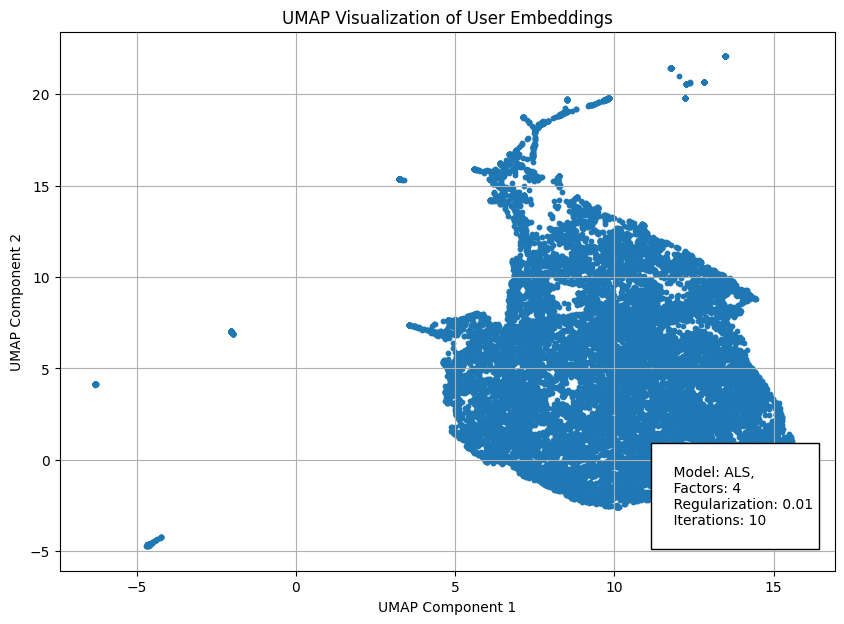

CPU times: user 1min 11s, sys: 4.37 s, total: 1min 16s
Wall time: 16.6 s


In [234]:
%%time 

def building_model(factors):
    model_als = AlternatingLeastSquares(factors=factors, # скрытые факторы
                                    regularization=0.001, # регуляризация, от переобучения модели
                                    iterations=100, 
                                    calculate_training_loss=True)
    
    model_als.fit(csr_matrix(user_item_matrix).tocsr(), show_progress=True)
    return model_als

model_als = building_model(20)

reducer = umap.UMAP(n_components=2) # to 2-dimension
umap_embeddings_users = reducer.fit_transform(user_factors)
umap_embeddings_items = reducer.fit_transform(item_factors)

processor.figure_umap_embeddings(model, umap_embeddings_users, 'UMAP Visualization of User Embeddings')

In [226]:
model = model_als

# MODEL INFORMATION
print('item_factors:', model.item_factors.shape)
print('user_factors:', model.user_factors.shape)

# эмбеддинги items
item_factors=pd.DataFrame(model.item_factors)

# эмбеддинги users
user_factors=pd.DataFrame(model.user_factors)
# user_factors.head(3)

item_factors: (690, 4)
user_factors: (20000, 4)


In [107]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from modules import processor

### test user

In [108]:

TEST_USER_ID = 2

def reccomendation(model, n,  userid, user_item_matrix, userid_to_id):
    recs = model.recommend(userid=userid_to_id[userid],  
                        user_items=csr_matrix(user_item_matrix.loc[userid_to_id[TEST_USER_ID]]).tocsr(),  
                        N=n, 
                        recalculate_user=True,
                        filter_already_liked_items=False)
    return recs[0]

recs = reccomendation(model_als, 10, TEST_USER_ID, user_item_matrix, userid_to_id)
recs

array([ 22, 342, 341, 343, 379, 391,   4,  13, 338,  82], dtype=int32)

In [109]:
user_df = test_df[test_df["user_id"]==TEST_USER_ID]

In [17]:
def calculate_counttable_by_columnname(df, column_name):
        """
        Calculate a count table for a column.
        
        Args:
            df (DataFrame): The DataFrame to calculate the count table for.
            column_name (str): The name of the column to calculate the count table for.
            
        Returns:
            DataFrame: The count table.
        """
        counts = df[column_name].value_counts().reset_index()
        counts.columns = [column_name, 'count']
        counts = counts.sort_values(by='count')
        return counts

calculate_counttable_by_columnname(user_df, 'cart').sort_values(by="count",ascending=False).head(5)

,cart,count
0,23,11
1,57,10
2,61,8
3,82,7
4,403,7


In [18]:
# user_df

### reccomend

In [110]:
k = 30
score_more = 0.99
test_users = test_df.user_id.unique()
test_carts = test_df.cart.unique()
# k = test_carts.shape[0]


In [111]:
def calculate_recommendations_for_user(userid, model, k, user_item_matrix=user_item_matrix, userid_to_id=userid_to_id):

    def reccomendation(model, n,  userid, user_item_matrix, userid_to_id):
        ids, scores = model.recommend(userid=userid_to_id[userid],  
                            user_items=csr_matrix(user_item_matrix.loc[userid_to_id[userid]]).tocsr(),  
                            N=n, 
                            recalculate_user=True,
                            filter_already_liked_items=False)
        return ids, scores
    
    return reccomendation(model, k, userid, user_item_matrix, userid_to_id)


In [32]:
# userid = 1

# ids, scores = calculate_recommendations_for_user(userid, model, k)

# test_results = pd.DataFrame(columns=['user_id','cart_id','target'])


# for userid in [userid]:

#     ids, scores = calculate_recommendations_for_user(userid, model, k)

#     for i in range(k):
#         test_results=pd.concat([pd.DataFrame([
#             {   
#                 'user_id': userid, 
#                 'cart_id': cart_id, 
#                 'target': target
#             }]),
#             test_results],ignore_index=True)

In [115]:
test_df

,user_id,order_completed_at,cart
3097178,0,2020-09-02 07:38:25,803
3097179,0,2020-09-02 07:38:25,170
3097180,0,2020-09-02 07:38:25,84
3097181,0,2020-09-02 07:38:25,61
3097182,0,2020-09-02 07:38:25,440
...,...,...,...
3106843,19998,2020-09-02 15:03:23,84
3106844,19998,2020-09-02 15:03:23,798
3106845,19998,2020-09-02 15:03:23,409
3106846,19998,2020-09-02 15:03:23,19


## submit df

In [116]:
submit_df = sample_sumbission.copy()
# submit_df = test_df.copy()

# Разделить каждую ячейку в колонке на два столбца
submit_df[['user_id', 'cart_id']] = submit_df['id'].str.split(';', expand=True)
submit_df['user_id'] = submit_df['user_id'].astype(int)
submit_df['cart_id'] = submit_df['cart_id'].astype(int)

In [24]:
submit_df.head(2)

,id,target,user_id,cart_id
0,0;133,0,0,133
1,0;5,1,0,5


In [25]:
# create reccomended df

def create_and_save_df_of_reccomended_lists(submit_df):

    users_for_predictions = submit_df.user_id.unique()
    cart_user = submit_df[['user_id', 'cart_id']]

    list_of_carts = pd.DataFrame(columns=['user_id','carts'])

    for userid in users_for_predictions:
        
        carts = cart_user[cart_user["user_id"]==userid].cart_id.to_list()

        list_of_carts=pd.concat([pd.DataFrame([
                {   
                    'user_id': userid, 
                    'carts': carts
                }]),
                list_of_carts],ignore_index=True)
        
    lists_rec = list_of_carts.sort_values(by='user_id').reset_index(drop=True)
    lists_rec.to_csv('lists_rec.csv', encoding='utf-8')
    return lists_rec

# lists_rec = create_and_save_df_of_reccomended_lists(submit_df)
lists_rec = pd.read_csv('lists_rec.csv', encoding='utf-8')
lists_rec.drop(columns=['Unnamed: 0'], inplace=True)
lists_rec.set_index('user_id', inplace=True)

In [26]:
lists_rec.head(5)

,carts
user_id,
0,"[133, 5, 10, 396, 14, 398, 399, 401, 402, 20, 405, 22, 25, 26, 411, 409, 157, 799, 803, 41, 170, 169, 430, 432, 821, 55, 440, 441, 57, 61, 82, 83, 84, 379, 382, 383]"
1,"[14, 19, 149, 23, 798, 803, 421, 169, 170, 171, 812, 302, 307, 54, 55, 204, 82, 86, 88, 231]"
3,"[134, 398, 399, 15, 16, 402, 19, 404, 148, 22, 14, 17, 27, 412, 411, 804, 41, 42, 43, 430, 179, 57, 442, 61, 62, 64, 712, 142, 77, 84, 88, 91, 92, 100, 376, 380, 382, 383]"
4,"[384, 387, 388, 5, 134, 391, 133, 398, 16, 400, 17, 19, 21, 22, 409, 26, 29, 799, 800, 420, 421, 805, 425, 812, 430, 431, 50, 179, 54, 55, 57, 443, 61, 712, 204, 77, 84, 85, 87, 88, 89, 98, 99, 100, 101, 102, 619, 107, 379, 383]"
5,"[384, 385, 386, 388, 389, 390, 391, 392, 9, 397, 14, 398, 17, 402, 19, 20, 406, 23, 24, 409, 25, 26, 412, 29, 798, 799, 31, 408, 419, 420, 421, 423, 808, 169, 170, 41, 42, 173, 813, 430, 434, 436, 439, 440, 57, 441, 443, 445, 446, 63, 64, 61, 834, 833, 831, 197, 712, 842, 75, 203, 848, 84, 88, 731, 92, 732, 248, 352, 109, 366, 22, 376, 379, 380, 382, 383]"


In [27]:
def calculate_recommendations_for_user(userid, model, k, user_item_matrix=user_item_matrix, userid_to_id=userid_to_id):

    def reccomendation(model, n,  userid, user_item_matrix, userid_to_id):
        ids, scores = model.recommend(userid=userid_to_id[userid],  
                            user_items=csr_matrix(user_item_matrix.loc[userid_to_id[userid]]).tocsr(),  
                            N=n, 
                            recalculate_user=True,
                            filter_already_liked_items=False)
        return ids, scores
    
    return reccomendation(model, k, userid, user_item_matrix, userid_to_id)


In [28]:
carts_value = lists_rec.loc[0, 'carts']
carts_list = eval(carts_value)
# carts_list
# eval(lists_rec.loc[0, 'carts'])

In [29]:
# users_ids = lists_rec["user_id"].unique()

users_ids = [0]
score_level = 0.7

df_test_results = pd.DataFrame(columns=['user_id','cart_id','target'])


def concat_to_df(df, userid, cartid, target):
    df=pd.concat([pd.DataFrame([
                    {   
                        'user_id': userid, 
                        'cart_id': cartid, 
                        'target': target
                    }]),
                    df],ignore_index=True)
    return df


for userid in users_ids:

    target = 0

    unique_cart_items = test_df[test_df["user_id"]==userid]["cart"].unique().tolist()
    k = len(unique_cart_items)
    carts_for_recs = eval(lists_rec.loc[userid, 'carts'])

    ids, scores = calculate_recommendations_for_user(userid, model, k)
    ids = ids.tolist()
    recs_for_user = pd.DataFrame({'score': scores}, index=ids)

    for cart in carts_for_recs:
        
        if cart in ids:
            score = float(recs_for_user.loc[cart,'score'])

            if score > score_level:
                target = 1
            else:
                terget = 0
        
            df_test_results=concat_to_df(df_test_results, userid, cart, target)

        else:
            target = 0
            df_test_results=concat_to_df(df_test_results, userid, cart, target)

In [31]:
df_test_results.head(50)

,user_id,cart_id,target
0,0,383,0
1,0,382,0
2,0,379,0
3,0,84,1
4,0,83,0
5,0,82,1
6,0,61,1
7,0,57,1
8,0,441,0
9,0,440,0


In [33]:
# Соединение значений в двух колонках через точку с запятой
df_test_results['id'] = df_test_results.apply(lambda row: f"{row['user_id']};{row['cart_id']}", axis=1)

df_test_results.head(2)

,user_id,cart_id,target,id
0,0,383,0,0;383
1,0,382,0,0;382


In [37]:
result = df_test_results[['id', 'target']].copy()
result

,id,target
0,0;383,0
1,0;382,0
2,0;379,0
3,0;84,1
4,0;83,0
5,0;82,1
6,0;61,1
7,0;57,1
8,0;441,0
9,0;440,0


# train df

In [118]:
train_df.head(1)

,user_id,order_completed_at,cart
2422913,0,2020-07-19 09:59:17,20


In [119]:
submit_df.head(1)

,id,target,user_id,cart_id
0,0;133,0,0,133


In [ ]:
# create reccomended df

def create_and_save_df_of_reccomended_lists(submit_df):

    users_for_predictions = submit_df.user_id.unique()
    cart_user = submit_df[['user_id', 'cart_id']]

    list_of_carts = pd.DataFrame(columns=['user_id','carts'])

    for userid in users_for_predictions:
        
        carts = cart_user[cart_user["user_id"]==userid].cart_id.to_list()

        list_of_carts=pd.concat([pd.DataFrame([
                {   
                    'user_id': userid, 
                    'carts': carts
                }]),
                list_of_carts],ignore_index=True)
        
    lists_rec = list_of_carts.sort_values(by='user_id').reset_index(drop=True)
    lists_rec.to_csv('lists_rec.csv', encoding='utf-8')
    return lists_rec




lists_rec = create_and_save_df_of_reccomended_lists(submit_df)
lists_rec
# lists_rec = pd.read_csv('lists_rec2.csv', encoding='utf-8')
# lists_rec.drop(columns=['Unnamed: 0'], inplace=True)
# lists_rec.set_index('user_id', inplace=True)

In [122]:
submit_df = test_df[['user_id','cart']].copy()
submit_df = submit_df.rename(columns={'cart': 'cart_id'}) 
submit_df.drop_duplicates().reset_index(drop=True)
lists_rec = create_and_save_df_of_reccomended_lists(submit_df)

In [123]:
lists_rec

,user_id,carts
0,0,"[803, 170, 84, 61, 440, 57, 55, 401, 398, 399, 169]"
1,1,"[88, 302, 803, 307, 54, 55, 14, 169, 149]"
2,2,"[383, 87, 382, 23, 100, 160, 15]"
3,3,"[64, 22, 380, 382, 383, 19, 43, 27, 179, 57, 14, 92, 41, 17, 142]"
4,4,"[57, 398, 29, 84, 430, 87, 19, 98, 54, 409, 400]"
...,...,...
19995,19995,[712]
19996,19996,"[443, 57, 14]"
19997,19997,"[244, 49, 243, 239, 131, 420, 232, 231, 55, 84, 57, 87, 135, 430, 61, 227, 160]"
19998,19998,"[84, 798, 409, 19]"


In [129]:
users_ids=[0]

unique_carts_all_ds = raw_data.cart.unique()

for userid in users_ids:

    target = 0

    unique_cart_items = test_df[test_df["user_id"]==userid]["cart"].unique().tolist()
    k = len(unique_cart_items)
    # carts_for_recs = eval(lists_rec.loc[userid, 'carts'])
    carts_for_recs = unique_cart_items

    ids, scores = calculate_recommendations_for_user(userid, model, k)
    ids = ids.tolist()
    recs_for_user = pd.DataFrame({'score': scores}, index=ids)

    for cart in carts_for_recs:
        
        if cart in ids:
            score = float(recs_for_user.loc[cart,'score'])

            if score > score_level:
                target = 1
            else:
                terget = 0
        
            df_test_results=concat_to_df(df_test_results, userid, cart, target)

        else:
            target = 0
            df_test_results=concat_to_df(df_test_results, userid, cart, target)


df_test_results.head(2)

,user_id,cart_id,target,id
0,0,169,0,NaN
1,0,399,0,NaN


In [139]:
# Уникальные группы во всем тестовом датасете
unique_carts_all_ds = raw_data.cart.unique()
unique_carts_all_ds.shape[0]

881

In [140]:
# Все юзеры во всем тестовом датасете
unique_users_all_ds = raw_data.user_id.unique()
unique_users_all_ds.shape[0]

20000

In [235]:
users_ids = [1]
# users_ids = unique_users_all_ds
carts_ids = unique_carts_all_ds

score_1_level = 0.6
score_0_level = 0.1
score_err_level = 0.01

k = unique_carts_all_ds.shape[0]

df_test_results_1 = pd.DataFrame(columns=['user_id','cart_id','score'])

def concat_to_df(df, userid, cartid, score):
    df=pd.concat([pd.DataFrame([
                    {   
                        'user_id': userid, 
                        'cart_id': cartid, 
                        'score': score
                    }]),
                    df],ignore_index=True)
    return df

for userid in users_ids:
    # print(userid)

    ids, scores = calculate_recommendations_for_user(userid, model, k)
    ids = ids.tolist()
    recs_for_user = pd.DataFrame({'score': scores}, index=ids)
    
    print(ids)
    # print(recs_for_user)

    for cartid in ids:
        if cartid != 0:
            # print(cartid)
            score = recs_for_user.loc[cartid,'score']
            # print(score)

            df_test_results_1=concat_to_df(df_test_results_1, userid, cartid, score)


df_test_results_1.sort_values(by='score', ascending=False).head(15)  
 

[361, 36, 13, 384, 48, 22, 158, 37, 357, 78, 342, 47, 379, 368, 341, 8, 343, 79, 16, 371, 18, 617, 354, 347, 38, 28, 4, 335, 370, 82, 20, 355, 26, 15, 338, 146, 30, 167, 623, 179, 159, 58, 558, 396, 359, 627, 339, 19, 362, 14, 350, 160, 29, 154, 90, 618, 9, 367, 162, 344, 631, 25, 21, 351, 124, 378, 336, 161, 24, 380, 76, 138, 89, 23, 10, 404, 135, 373, 402, 391, 360, 66, 372, 346, 0, 356, 92, 394, 75, 632, 345, 147, 365, 392, 358, 53, 55, 184, 393, 401, 626, 67, 400, 397, 80, 385, 366, 381, 348, 94, 88, 212, 91, 619, 369, 364, 168, 186, 102, 638, 148, 95, 278, 157, 405, 142, 340, 125, 149, 54, 128, 559, 353, 178, 382, 624, 655, 5, 12, 150, 49, 17, 622, 229, 11, 376, 131, 386, 86, 81, 97, 211, 180, 661, 663, 99, 42, 363, 383, 403, 56, 133, 33, 398, 127, 121, 265, 93, 656, 72, 659, 210, 625, 321, 395, 137, 375, 96, 242, 129, 201, 520, 192, 165, 230, 62, 59, 374, 322, 349, 57, 621, 100, 247, 329, 139, 123, 236, 166, 41, 98, 217, 585, 660, 639, 140, 224, 183, 181, 670, 144, 214, 219, 645,

,user_id,cart_id,score
688,1,361,0.275176
687,1,36,0.242953
686,1,13,0.236715
685,1,384,0.218730
684,1,48,0.207094
683,1,22,0.203086
682,1,158,0.199401
681,1,37,0.198287
680,1,357,0.197108
679,1,78,0.188099


In [236]:
test_df[test_df['user_id']==1]

,user_id,order_completed_at,cart
2348244,1,2020-07-14 10:20:58,88
2348245,1,2020-07-14 10:20:58,302
2348246,1,2020-07-14 10:20:58,803
2348247,1,2020-07-14 10:20:58,307
2348248,1,2020-07-14 10:20:58,54
2348249,1,2020-07-14 10:20:58,55
2348250,1,2020-07-14 10:20:58,14
2348251,1,2020-07-14 10:20:58,169
2348252,1,2020-07-14 10:20:58,149


In [178]:
recs_for_user.keys()

Index(['score'], dtype='object')